# Fall 2021 CS543/ECE549 Projects

## Grading of Diabetic Retinopathy Severity Level


In [1]:
import numpy as np 
import pandas as pd
import cv2
from PIL import Image
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import roc_curve, roc_auc_score
from keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model, load_model

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [2]:
# References: https://www.kaggle.com/varunsharmaml/vgg16-dr
# https://www.kaggle.com/swethapailla/machinevision-capsnet-dr

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0" 
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# EDA

In [4]:
y = pd.read_csv('data\\trainLabels.csv')
y['filenames'] = [i+".jpeg" for i in y['image'].values]

y.head()


,image,level,filenames
0,10_left,0,10_left.jpeg
1,10_right,0,10_right.jpeg
2,13_left,0,13_left.jpeg
3,13_right,0,13_right.jpeg
4,15_left,1,15_left.jpeg


0    25810
2     5292
1     2443
3      873
4      708
Name: level, dtype: int64

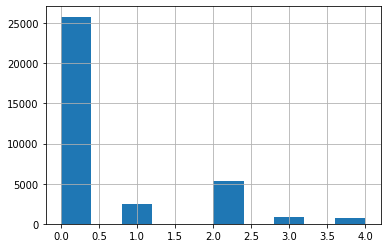

In [5]:
y['level'].hist()
y['level'].value_counts()

# Preparing & Preprocessing Data

In [6]:
train_y, val_y = train_test_split(y, test_size=0.3)
val_y, test_y = train_test_split(val_y, test_size=1.0/3.0)

train_y.shape, val_y.shape, test_y.shape

((24588, 3), (7025, 3), (3513, 3))

In [7]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# https://arxiv.org/pdf/1409.1556.pdf

vgg_input_size = (224, 224)
batch_size = 32


datagen = ImageDataGenerator()


train_gen = datagen.flow_from_dataframe(
                                            dataframe = train_y, directory='data\\resized_train\\resized_train', x_col='filenames', y_col='level',
                                            weight_col=None, target_size=vgg_input_size, color_mode='rgb',
                                            classes=None, class_mode='raw', batch_size=batch_size, shuffle=True,
                                            seed=None, save_to_dir=None, save_prefix='',
                                            save_format='png', subset=None, interpolation='nearest',
                                            validate_filenames=True, 
                                        )

val_gen = datagen.flow_from_dataframe(
                                            dataframe = val_y, directory='data\\resized_train\\resized_train', x_col='filenames', y_col='level',
                                            weight_col=None, target_size=vgg_input_size, color_mode='rgb',
                                            classes=None, class_mode='raw', batch_size=batch_size, shuffle=True,
                                            seed=None, save_to_dir=None, save_prefix='',
                                            save_format='png', subset=None, interpolation='nearest',
                                            validate_filenames=True, 
                                        )

test_gen = datagen.flow_from_dataframe(
                                            dataframe = test_y, directory='data\\resized_train\\resized_train', x_col='filenames', y_col='level',
                                            weight_col=None, target_size=vgg_input_size, color_mode='rgb',
                                            classes=None, class_mode='raw', batch_size=batch_size, shuffle=True,
                                            seed=None, save_to_dir=None, save_prefix='',
                                            save_format='png', subset=None, interpolation='nearest',
                                            validate_filenames=True, 
                                        )






Found 24588 validated image filenames.
Found 7025 validated image filenames.
Found 3513 validated image filenames.


model.fit(
        train_gen,
        steps_per_epoch=2000,
        epochs=50,
        validation_data=val_gen,
        validation_steps=800)


# VGG 16 & VGG 19

In [8]:

dir_0 = 'pretrained_weights\\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
dir_1 = 'pretrained_weights\\vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'



M0 = VGG16(
    include_top=False, weights=dir_0, input_tensor=None,
    input_shape=(224,224,3),
    classifier_activation='softmax'
)

M1 = VGG19(
    include_top=False, weights=dir_1, input_tensor=None,
    input_shape=(224,224,3),
    classifier_activation='softmax'
)


M0_og = tf.keras.applications.vgg16.VGG16(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

M1_og = tf.keras.applications.vgg19.VGG19(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)






In [9]:
M0_og.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
M1_og.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
M0.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
M1.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
# https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras

def build_model(model, n_labels):
    
    
    x = model.layers[-2].output
    output = Dense(units=n_labels, activation='softmax')(x)
    model = Model(inputs=model.input, outputs=output)
    
    
    for layer in model.layers[:12]:
        layer.trainable = False
    
    
        
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

    

In [14]:
M0 = build_model(M0_og, 5)
M0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
M1 = build_model(M1_og, 5)
M1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [16]:
model_chk_0 = ModelCheckpoint("output\\vgg16_model.h5", save_best_only=True, monitor="val_accuracy")
model_chk_1 = ModelCheckpoint("output\\vgg19_model.h5", save_best_only=True, monitor="val_accuracy")

steps_per_epoch = train_gen.n // batch_size
validation_steps = val_gen.n // batch_size
epochs = 10

H0 = M0.fit_generator(train_gen, steps_per_epoch = steps_per_epoch,
                    validation_data=val_gen, validation_steps=validation_steps,
                    epochs=epochs, workers=4, callbacks=[model_chk_0])

H1 = M1.fit_generator(train_gen, steps_per_epoch = steps_per_epoch,
                    validation_data=val_gen, validation_steps=validation_steps,
                    epochs=epochs, workers=4, callbacks=[model_chk_1])



C:\Users\wangh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
768/768 [==============================] - 121s 149ms/step - loss: 0.8220 - accuracy: 0.7384 - val_loss: 0.7698 - val_accuracy: 0.7453
Epoch 2/10
768/768 [==============================] - 114s 148ms/step - loss: 0.7352 - accuracy: 0.7560 - val_loss: 0.7695 - val_accuracy: 0.7506
Epoch 3/10
768/768 [==============================] - 102s 132ms/step - loss: 0.6971 - accuracy: 0.7667 - val_loss: 0.7145 - val_accuracy: 0.7573
Epoch 4/10
768/768 [==============================] - 115s 150ms/step - loss: 0.6606 - accuracy: 0.7789 - val_loss: 0.6934 - val_accuracy: 0.7610
Epoch 5/10
768/768 [==============================] - 107s 139ms/step - loss: 0.6267 - accuracy: 0.7915 - val_loss: 0.7183 - val_accuracy: 0.7668
Epoch 6/10
768/768 [==============================] - 107s 139ms/step - loss: 0.5871 - accuracy: 0.8062 - val_loss: 0.7276 - val_accuracy: 0.7447
Epoch 7/10
768/768 [==============================] - 108s 140ms/step - loss: 0.5350 - accuracy: 0.8226 - val_loss: 0.7133 -

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
#from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from prettytable import PrettyTable
# Test model using test dataset
def test(model, y_test, test_gen):
    
    x_test = test_gen
    y_pred = model.predict(x_test, batch_size=100)
    print("Groud Truth values: ",y_test.shape)
    print(y_test)
    print('-'*40)
    print("Predicted values: ",y_pred.shape)
    print(y_pred)
    pred = np.argmax(y_pred, axis=1)
    test = np.argmax(y_test, axis=1)
    #pred = y_pred.round()
    #test = y_test.round()
    accuracy = (np.sum(np.argmax(y_pred, 1) == np.argmax(y_test,1))/y_test.shape[0])
    precision = metrics.precision_score(test, pred,average='weighted')
    recall = metrics.recall_score(test, pred,average='weighted')
    f1 = metrics.f1_score(test, pred,average='weighted')
    print(" ")
    Cnn_Table = PrettyTable(['vgg Performance Metrics', '%'])
  
    # Add rows
    Cnn_Table.add_row(['Accuracy ',accuracy])
    Cnn_Table.add_row(['Precision',precision])
    Cnn_Table.add_row(['Recall/Sensitivity   ',recall])
    Cnn_Table.add_row(['F1_score ',f1])
    #myTable.add_row(['MLP_Confusion_Matrix',matrix])

    print(Cnn_Table)

    #Confusion Matrix
    print(" ")
    matrix = metrics.confusion_matrix(test, pred)
    print(" ")
    print('vgg_Confusion_Matrix:')
    print(" ")
    print(matrix)
    print(" ")
    
    print("classification_report: ")
    print('-'*40)
    print(metrics.classification_report(test, pred))
    
    
   
    
    # Plotting ROC curve
    y = y_test
    # Binarize the output
    y = label_binarize(y, classes=[0, 1, 2, 3, 4])
    n_classes = y.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC for specific class
    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Receiver operating characteristic to specific class')
    plt.legend(loc="lower right")
    plt.show()
    
    print(' ')
    
    # Plot ROC curve for multi class
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
print("Model is ready to Test")

Model is ready to Test


In [27]:
test_y['level'].values

array([0, 2, 2, ..., 0, 2, 0], dtype=int64)

In [28]:
from tensorflow.keras.utils import to_categorical

y_test = test_y['level'].map(lambda x: to_categorical(x, 5))
y_test = np.asarray(list(y_test))
y_test

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

Groud Truth values:  (3513, 5)
[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]
----------------------------------------
Predicted values:  (3513, 5)
[[8.1800735e-01 1.7436899e-01 7.1452865e-03 4.4646030e-04 3.1919844e-05]
 [9.7836041e-01 2.0387776e-02 1.2336988e-03 1.7042912e-05 1.0870384e-06]
 [9.6300596e-01 3.6425717e-02 5.6193757e-04 6.3218763e-06 7.2327509e-08]
 ...
 [9.7302926e-01 2.5730841e-02 1.2242039e-03 1.5218734e-05 4.4838654e-07]
 [9.9667871e-01 3.1287947e-03 1.8865250e-04 3.5518881e-06 2.3280158e-07]
 [9.6640956e-01 2.9532392e-02 3.9316053e-03 1.1640793e-04 1.0125416e-05]]
 
+-------------------------+--------------------+
| vgg Performance Metrics |         %          |
+-------------------------+--------------------+
|        Accuracy         | 0.6641047537717051 |
|        Precision        | 0.5646885694330759 |
|  Recall/Sensitivity     | 0.6641047537717051 |
|        F1_score         | 0.601409312125845

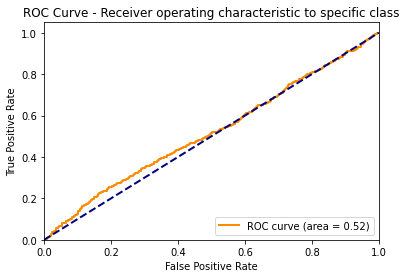

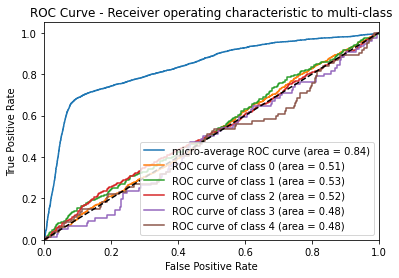

In [29]:
test(M0, y_test, test_gen)

Groud Truth values:  (3513, 5)
[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]
----------------------------------------
Predicted values:  (3513, 5)
[[9.5748192e-01 3.3855233e-02 8.6265132e-03 3.4030258e-05 2.2501777e-06]
 [9.3999517e-01 4.0085118e-02 1.9648623e-02 2.3121154e-04 3.9778708e-05]
 [9.2756176e-01 4.1610029e-02 3.0551836e-02 2.1872051e-04 5.7702800e-05]
 ...
 [8.4029639e-01 1.1653868e-01 4.2650435e-02 4.5132308e-04 6.3209867e-05]
 [9.1003144e-01 4.9873542e-02 3.8035862e-02 1.3733261e-03 6.8585976e-04]
 [9.6592462e-01 2.4256324e-02 9.7209439e-03 8.0541475e-05 1.7602337e-05]]
 
+-------------------------+--------------------+
| vgg Performance Metrics |         %          |
+-------------------------+--------------------+
|        Accuracy         | 0.6874466268146883 |
|        Precision        | 0.5434703791159176 |
|  Recall/Sensitivity     | 0.6874466268146883 |
|        F1_score         |  0.59977640238316

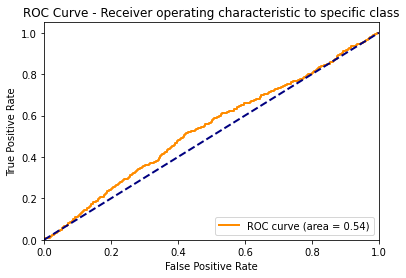

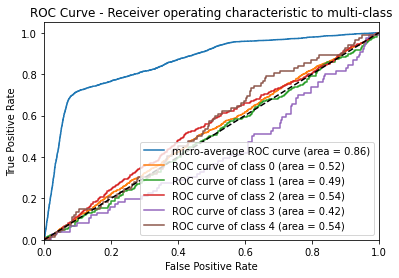

In [30]:
test(M1, y_test, test_gen)

In [32]:
M0.evaluate_generator(test_gen, steps=test_gen.n/batch_size, verbose=1)

C:\Users\wangh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


109/109 [==============================] - 23s 210ms/step - loss: 0.9989 - accuracy: 0.7543


[0.9988712668418884, 0.7543410062789917]

In [33]:
M1.evaluate_generator(val_gen, steps=test_gen.n/batch_size, verbose=1)

109/109 [==============================] - 23s 210ms/step - loss: 0.9150 - accuracy: 0.7571


[0.9150334000587463, 0.7571022510528564]